In [1]:
import pandas as pd
import numpy as np
import time
import math
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.utils.data as Data

train = pd.read_csv('../task2/HS300V2_clean_data/clean_train.csv')
test = pd.read_csv('../task2/HS300V2_clean_data/clean_test.csv')

In [2]:
# timer function
def timeSince(since):
    now = time.time()
    s = now-since
    m = math.floor(s/60)
    s-= m*60
    return '%dm %ds' % (m,s)

In [3]:
class pearson_loss(nn.Module):
    def __init__(self):
        super().__init__()
      
    # use sample standard deviation
    def forward(self,x,y):
        cov = torch.mean(x*y)-torch.mean(x)*torch.mean(y)
        var = torch.std(x)*torch.std(y)
        return -1*cov/var+1
    
class pearson_loss2(nn.Module):
    def __init__(self):
        super().__init__()
    
    # scale std in pearson_loss
    def forward(self,x,y):
        cov = torch.mean(x*y)-torch.mean(x)*torch.mean(y)
        var = torch.std(x)*torch.std(y)*(1-1/x.shape[0])
        return -1*cov/var+1

In [4]:
class CNN(nn.Module):
    def __init__(self,window,factor_num):
        super(CNN,self).__init__()
        
        # torch.nn.Conv1d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
        self.conv1 = nn.Conv1d(in_channels=factor_num,out_channels=64,kernel_size=2,stride=2)
        self.conv2 = nn.Conv1d(in_channels=factor_num,out_channels=64,kernel_size=4,stride=4)
        self.conv3 = nn.Conv1d(in_channels=factor_num,out_channels=64,kernel_size=8,stride=8)
        
        self.fc1 = nn.Linear(factor_num,64)
        self.fc2 = nn.Linear(64,1)

        self.bn1 = nn.BatchNorm1d(64)
        self.dropout = nn.Dropout(p=0.5)
                
    def forward(self,x):
        
        temp1 = self.conv1(x.permute(0,2,1))
        temp1 = self.bn1(temp1)
        temp1 = torch.tanh(temp1)*torch.sigmoid(temp1)+temp1
        temp1 = temp1.permute(0,2,1)
        temp1= self.fc2(temp1)
        temp1,idx1 = temp1.max(1)
        
        temp2 = self.conv2(x.permute(0,2,1))
        temp2 = self.bn1(temp2)
        temp2 = torch.tanh(temp2)*torch.sigmoid(temp2)+temp2
        temp2 = temp2.permute(0,2,1)
        temp2 = self.fc2(temp2)
        temp2,idx2 = temp2.max(1)
        
        temp3 = self.conv3(x.permute(0,2,1))
        temp3 = self.bn1(temp3)
        temp3 = torch.tanh(temp3)*torch.sigmoid(temp3)+temp3
        temp3 = temp3.permute(0,2,1)
        temp3 = self.fc2(temp3)
        temp3,idx3 = temp3.max(1)
        
        temp4 = x[:,-1,:]
        temp4 = self.fc1(temp4)
        temp4 = torch.tanh(temp4)
        temp4 = self.fc2(temp4)
        temp4 = torch.tanh(temp4)
        
        final = temp1+temp2+temp3+temp4
        
        return final

In [5]:
def data_process(data,window,option):
    data = data.sort_values(['stock_code','trade_date'])
    stock_code = list(set(data['stock_code']))
    select_stock_code = []
    
    # select stock that has enough factor time series data
    for i in range(len(stock_code)):
        x = data[data['stock_code']==stock_code[i]]
        if x.shape[0]>=window:
            select_stock_code.append(stock_code[i])
    
    # for testing set, record factor time series data, predictions' corresponding stock_code and trade_date
    if option == 'test':
        list1,list2 = [],[]
        for i in range(len(select_stock_code)):
            x = np.array(data[data['stock_code']==select_stock_code[i]])
            row,col = x.shape
            for j in range(row-window+1):
                list1.append(x[j:j+window,2:])
                list2.append(x[j+window-1,:2])
        test_X = torch.tensor(np.array(list1),dtype=torch.float32)
        test_info = torch.tensor(np.array(list2),dtype=torch.float32)
        return test_X,test_info
    
    # for training set or validation set, record factor time series data and predictions
    else:
        list1,list2 = [],[]
        for i in range(len(select_stock_code)):
            x = np.array(data[data['stock_code']==select_stock_code[i]])
            row,col = x.shape
            for j in range(row-window+1):
                list1.append(x[j:j+window,3:])
                list2.append(x[j+window-1,2])
        X = torch.tensor(np.array(list1),dtype=torch.float32)
        y = torch.tensor(np.array(list2),dtype=torch.float32)
        return X,y

In [6]:
# 95% data as a training set, 5% data as a validation set
num = len(list(set(train['trade_date'])))
split_date = math.floor(num*0.95)+1215
train_all = train[train['trade_date']<=split_date]
valid_all = train[train['trade_date']>split_date]

In [7]:
window = 10
train_X,train_y = data_process(train_all,window,'train')
valid_X,valid_y = data_process(valid_all,window,'valid')
test_X,test_info = data_process(test,window,'test')

In [8]:
# check the shape of tensor
print(train_X.shape,train_y.shape,valid_X.shape,valid_y.shape,test_X.shape,test_info.shape)

torch.Size([591707, 10, 282]) torch.Size([591707]) torch.Size([29103, 10, 282]) torch.Size([29103]) torch.Size([105135, 10, 282]) torch.Size([105135, 2])


In [9]:
factor_num = train.shape[1]-3
epochs = 5
learning_rate = 1e-3
batch_size = 512

In [10]:
train_dataset = Data.TensorDataset(train_X,train_y)
valid_dataset = Data.TensorDataset(valid_X,valid_y)
train_loader = Data.DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)
valid_loader = Data.DataLoader(dataset=valid_dataset,batch_size=batch_size,shuffle=True)

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
# recall: def __init__(self,window,factor_num):
model = CNN(window,factor_num).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
criterion = pearson_loss().to(device)

In [22]:
# check total counts n of model parameters, n should be less than train.shape[0]
sum(p.numel() for p in model.parameters() if p.requires_grad)

271169

epoch 1 time: 0m 12s
epoch 2 time: 0m 23s
epoch 3 time: 0m 35s
epoch 4 time: 0m 46s
epoch 5 time: 0m 58s


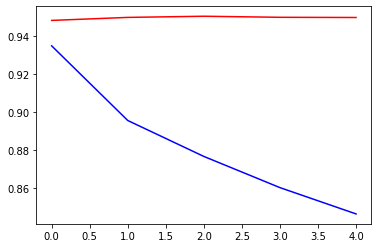

In [23]:
start = time.time()
train_loss = []
valid_loss = [] 
train_epoch_loss = 0
valid_epoch_loss = 0
valid_min_loss = float('inf')
for epoch in range(epochs):
    model.train()
    for t_batch_idx,(t_inputs,t_labels) in enumerate(train_loader):
        t_inputs,t_labels = t_inputs.to(device),t_labels.to(device)
        t_pred = model(t_inputs)
        t_loss = criterion(t_pred.squeeze(1),t_labels)
        optimizer.zero_grad()
        t_loss.backward()
        optimizer.step()
        train_epoch_loss+=t_loss.item()
    
    model.eval()
    for v_batch_idx,(v_inputs,v_labels) in enumerate(valid_loader):
        v_inputs,v_labels = v_inputs.to(device),v_labels.to(device)
        v_pred = model(v_inputs)
        v_loss = criterion(v_pred.squeeze(1),v_labels)
        valid_epoch_loss+=v_loss.item()
            
    
    train_loss.append(train_epoch_loss/(t_batch_idx+1))
    
    # early stop 
    valid_avg_loss = valid_epoch_loss/(v_batch_idx+1)
    if valid_avg_loss/valid_min_loss>1.05:
        break
    else:
        valid_loss.append(valid_avg_loss)
        valid_min_loss = min(valid_loss)
    train_epoch_loss = 0
    valid_epoch_loss = 0 
    print('epoch %d time: %s'% (epoch+1,timeSince(start)))
    
plt.figure()
plt.plot(train_loss,'b-',valid_loss,'r-')
plt.show()

In [24]:
test_y = model.cpu()(test_X).detach().numpy()
test_info_np = test_info.numpy().astype(np.int64)

In [25]:
pred = []
for i in range(test_y.shape[0]):
     pred.append([str(test_info_np[i][1]),str(test_info_np[i][0]),str(test_y[i][0])])

In [26]:
pred

[['3411', '0', '0.5352058'],
 ['3412', '0', '0.31164098'],
 ['3413', '0', '0.61696863'],
 ['3414', '0', '0.4334488'],
 ['3415', '0', '0.1564225'],
 ['3416', '0', '0.38009426'],
 ['3417', '0', '0.38936892'],
 ['3418', '0', '0.07258868'],
 ['3419', '0', '0.16298753'],
 ['3420', '0', '0.2931783'],
 ['3421', '0', '-0.005543232'],
 ['3422', '0', '0.14158887'],
 ['3423', '0', '0.10211763'],
 ['3424', '0', '0.2339584'],
 ['3425', '0', '0.053941905'],
 ['3426', '0', '-0.043398976'],
 ['3427', '0', '-0.07766092'],
 ['3428', '0', '0.15095049'],
 ['3429', '0', '0.75154114'],
 ['3430', '0', '0.7135833'],
 ['3431', '0', '0.48516303'],
 ['3432', '0', '0.61269414'],
 ['3433', '0', '0.2795419'],
 ['3434', '0', '-0.21526277'],
 ['3435', '0', '0.6182389'],
 ['3436', '0', '0.40410554'],
 ['3437', '0', '0.045204118'],
 ['3438', '0', '0.38936627'],
 ['3439', '0', '-0.11648977'],
 ['3440', '0', '0.2012113'],
 ['3441', '0', '0.0906532'],
 ['3442', '0', '-0.6012952'],
 ['3443', '0', '0.47283503'],
 ['3444', '

In [27]:
from BenchmarkTestTool import submit_benchmark_test

data = pred
submitter = "qiuyuan"
dataset = "HS300V2"
comment = 'CNN'
submit_benchmark_test(submitter,data,dataset,comment,submit=False)

TEST STATUS: success
************************************************************
COMPLETENESS CHECK
************************************************************
average_daily_miss_num:  59
max_miss_day:  3408
max_miss_day_num:  300
max_miss_stock:  3337
max_miss_stock_num:  25
pred_miss_num:  3092
pred_miss_ratio:  0.0286
pred_num:  105135
true_num:  108227

************************************************************
SUBMIT SIGNAL PERFORMANCE
************************************************************
autocorrelation:  0.7389281090709763
comment:  CNN
dataset:  HS300V2
pearson:  0.04356175253394271
pearson_250:  0.03295737534790352
pearson_decay:  -9.988108523426871e-05
pearson_std:  0.0699026629619927
sid:  afecc3b148a1303b74d2cf7641925884
spearman:  0.04879687385019962
submit_time:  2021-05-08 07:51:08.577041
submitter:  qiuyuan
top30_win_rate:  0.4855524079320113

************************************************************
MODEL SCORE'S EXPOSURE ON RISKS AND INDUSTRIAL FACTORS (

In [235]:
# from BenchmarkTestTool import check_test_rank

# check_test_rank(submitter="all",rank_by="pearson")

**************************************************
BENCHMARK测试榜排名:
**************************************************
*指标说明:
pearson:皮尔森相关系数
prs_dcy:信号相关性每日衰减系数
prs_250:最近250天（一年）的pearson均值
sprm:序相关性，斯皮尔曼相关系数
top30_win:信号每日前30名有正超额收益的胜率
ac:信号自相关性

0. 
+-------------------+-----------+---------+--------------------------+---------+
|    submit_time    | submitter | dataset |         comment          | pearson |
+-------------------+-----------+---------+--------------------------+---------+
| 21-04-18 13:23:54 |   ZhuLei  | HS300V2 | Person_1e-4_MLP_leakRelu | 0.05882 |
+-------------------+-----------+---------+--------------------------+---------+
+---------+---------+---------+--------+-----------+--------+
| prs_std | prs_dcy | prs_250 |  sprm  | top30_win |   ac   |
+---------+---------+---------+--------+-----------+--------+
|  0.0776 |  -8e-05 |  0.0502 | 0.0468 |   0.497   | 0.5959 |
+---------+---------+---------+--------+-----------+--------+
1. 
+-------------------+--------

In [ ]:
# class Wave_Block(nn.Module):

#     def __init__(self, in_channels, out_channels, dilation_rates, kernel_size):
#         super(Wave_Block, self).__init__()
#         self.num_rates = dilation_rates
#         self.convs = nn.ModuleList()
#         self.filter_convs = nn.ModuleList()
#         self.gate_convs = nn.ModuleList()

#         self.convs.append(nn.Conv1d(in_channels, out_channels, kernel_size=1))
#         dilation_rates = [2 ** i for i in range(dilation_rates)]
#         for dilation_rate in dilation_rates:
#             self.filter_convs.append(
#                 nn.Conv1d(out_channels, out_channels, kernel_size=kernel_size, padding=int((dilation_rate*(kernel_size-1))/2), dilation=dilation_rate))
#             self.gate_convs.append(
#                 nn.Conv1d(out_channels, out_channels, kernel_size=kernel_size, padding=int((dilation_rate*(kernel_size-1))/2), dilation=dilation_rate))
#             self.convs.append(nn.Conv1d(out_channels, out_channels, kernel_size=1))

#     def forward(self, x):
#         x = self.convs[0](x)
#         res = x
#         for i in range(self.num_rates):
#             x = torch.tanh(self.filter_convs[i](x)) * torch.sigmoid(self.gate_convs[i](x))
#             x = self.convs[i + 1](x)
#             res = res + x
#         return res
# # detail 
# class WaveNet2(nn.Module):
#     def __init__(self, in_channels, kernel_size=5):
#         super().__init__()
#         self.wave_block1 = Wave_Block(in_channels, 64, 2, kernel_size)
#         self.wave_block2 = Wave_Block(64, 32, 4, kernel_size)
#         self.fc = nn.Linear(32, 1)

#     def forward(self, x):
#         x = x.permute(0, 2, 1)
#         x = self.wave_block1(x)
#         x = self.wave_block2(x)
#         x = x.permute(0, 2, 1)
#         x = self.fc(x)
#         return x